In [207]:
import pandas as pd
import matplotlib.pyplot as plt

In [208]:
df = pd.read_csv("data_preprocessed.csv")
df.head()

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,emp_gender_cd,emp_children_cnt,emp_work_months_cnt,emp_citizenship_country_cd,emp_marital_status_cd,day_of_week,holiday_flg,approval_flg,bundle_flg,segment_region
0,0,139895392,42.0,1.0,msk,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,0.0,NaN,NaN,2,0,0,0,1.0
1,1,342841087,40.0,0.0,town,0.0,0.0,1.0,0.0,0.0,...,0.0,NaN,82.0,NaN,NaN,4,0,0,0,0.0
2,2,104017416,30.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,6,1,0,0,NaN
3,3,579880064,65.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,4,0,0,0,NaN
4,4,124379737,28.0,1.0,msk,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,0.0,NaN,NaN,4,0,0,0,1.0


In [209]:
df.shape

(17267, 35)

In [210]:
df["functional_cd"].value_counts() / df["functional_cd"].shape[0] * 100

functional_cd
Preapprove       48.236521
Afterfilling     12.607865
Utilization       9.445764
Cold              8.351190
Upsell            6.926507
Meeting           5.820351
Agreement         2.849366
Incoming          1.853246
Reutilization     1.227776
Downsell          1.169862
Activation        0.503851
BAF               0.457520
Autoleads         0.249030
Prolongation      0.237447
Deposit           0.057914
Refinancing       0.005791
Name: count, dtype: float64

In [211]:
df = df[df['functional_cd'].isin(['Preapprove', 'Afterfilling', 'Utilization', 'Cold', 'Upsell', 'Meeting'])]

In [212]:
df["bundle_nm"].isna().sum()

0

In [213]:
df["bundle_nm"].value_counts()

bundle_nm
Без подписки    12042
Pro              3506
Premium           232
Name: count, dtype: int64

In [214]:
df["bundle_nm"] = df["bundle_nm"].replace({"XXX": "Без подписки", "0": "Без подписки"})

In [215]:
df["bundle_nm"].value_counts()

bundle_nm
Без подписки    12042
Pro              3506
Premium           232
Name: count, dtype: int64

In [216]:
df = df.loc[df["bundle_nm"] != 'Premium']

In [217]:
df["bundle_nm"].value_counts()

bundle_nm
Без подписки    12042
Pro              3506
Name: count, dtype: int64

In [218]:
df["bundle_flg"] = df["bundle_nm"] == "Pro"

In [219]:
from scipy.stats import chi2_contingency, fisher_exact
filtered_data = df.copy()
# filtered_data = df[df['functional_cd'].isin(['Meeting', 'Upsell'])]
grouped = filtered_data.groupby(['functional_cd', 'product_cd', 'bundle_flg']).size().reset_index(name='group_size')

In [220]:
grouped[grouped['group_size'] < 20]

,functional_cd,product_cd,bundle_flg,group_size
0,Afterfilling,Car Loan,False,3
1,Afterfilling,Car Loan,True,1
10,Afterfilling,Investment,False,9
11,Afterfilling,Investment,True,5
15,Afterfilling,Mortgage Insurance,True,17
16,Afterfilling,Secured Loan,False,12
17,Afterfilling,Secured Loan,True,5
18,Cold,Car Loan,False,1
19,Cold,Casco,False,12
20,Cold,Casco,True,4


In [221]:
valid_products = (
    grouped.groupby(['product_cd', 'functional_cd'])['group_size']
    .min()
    .reset_index()
    .query('group_size >= 20')
)
valid_products

,product_cd,functional_cd,group_size
2,Car Loan,Preapprove,22
3,Casco,Afterfilling,125
5,Cash Loan,Afterfilling,49
7,Cash Loan,Preapprove,346
8,Cash Loan,Upsell,226
9,Credit Cards,Afterfilling,89
10,Credit Cards,Meeting,92
11,Credit Cards,Preapprove,1234
12,Credit Cards,Utilization,111
13,Debit Cards,Afterfilling,27


In [222]:
valid_combinations = valid_products[['product_cd', 'functional_cd']]
valid_combinations

,product_cd,functional_cd
2,Car Loan,Preapprove
3,Casco,Afterfilling
5,Cash Loan,Afterfilling
7,Cash Loan,Preapprove
8,Cash Loan,Upsell
9,Credit Cards,Afterfilling
10,Credit Cards,Meeting
11,Credit Cards,Preapprove
12,Credit Cards,Utilization
13,Debit Cards,Afterfilling


In [223]:
filtered_valid_data = filtered_data.merge(valid_combinations, on=['product_cd', 'functional_cd'])
filtered_valid_data

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,emp_gender_cd,emp_children_cnt,emp_work_months_cnt,emp_citizenship_country_cd,emp_marital_status_cd,day_of_week,holiday_flg,approval_flg,bundle_flg,segment_region
0,0,139895392,42.0,1.0,msk,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,0.0,NaN,NaN,2,0,0,False,1.0
1,2,104017416,30.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,6,1,0,False,NaN
2,3,579880064,65.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,4,0,0,False,NaN
3,4,124379737,28.0,1.0,msk,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,0.0,NaN,NaN,4,0,0,False,1.0
4,5,505902204,19.0,1.0,town,0.0,0.0,0.0,0.0,0.0,...,1.0,NaN,1.0,Россия,Холост/не замужем,0,0,1,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14881,18683,265874391,48.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,80.0,NaN,NaN,2,0,0,False,NaN
14882,18685,305282509,39.0,0.0,urban,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,1.0,NaN,NaN,3,0,1,False,1.0
14883,18686,191420290,48.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,NaN,1,0,0,False,NaN
14884,18687,211662819,54.0,1.0,msk,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,10.0,NaN,NaN,2,0,0,False,1.0


In [224]:
# Проверка статистической значимости
results = []
for (reason, product), group in filtered_valid_data.groupby(["functional_cd", "product_cd"]):
    # Таблица сопряженности
    contingency_table = pd.crosstab(group['bundle_flg'], group['approval_flg'])
    # Выбор теста (хи-квадрат или Фишера)
    if contingency_table.values.min() < 5:
        # Точный тест Фишера
        stat, p_value = fisher_exact(contingency_table, alternative='two-sided')
        test_type = 'Fisher'
    else:
        # Тест хи-квадрат
        stat, p_value, _, _ = chi2_contingency(contingency_table)
        test_type = 'Chi2'
    
    # Сохранение результата
    results.append({
        'reason': reason,
        'product': product,
        'test': test_type,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

# Конвертация результатов в DataFrame
results_df = pd.DataFrame(results)

results_df

,reason,product,test,p_value,significant
0,Afterfilling,Casco,Chi2,0.373168,False
1,Afterfilling,Cash Loan,Chi2,0.535004,False
2,Afterfilling,Credit Cards,Fisher,0.204133,False
3,Afterfilling,Debit Cards,Chi2,1.000000,False
4,Afterfilling,MVNO,Chi2,0.214222,False
5,Cold,MVNO,Chi2,0.554274,False
6,Cold,Mortgage Insurance,Fisher,0.692414,False
7,Meeting,Credit Cards,Chi2,0.702538,False
8,Meeting,Debit Cards,Chi2,0.869699,False
9,Preapprove,Car Loan,Fisher,0.624218,False


In [225]:
# Проверка статистической значимости
results = []
for product, group in filtered_valid_data.groupby("product_cd"):
    # Таблица сопряженности
    contingency_table = pd.crosstab(group['bundle_flg'], group['approval_flg'])
    # Выбор теста (хи-квадрат или Фишера)
    if contingency_table.values.min() < 5:
        # Точный тест Фишера
        stat, p_value = fisher_exact(contingency_table, alternative='two-sided')
        test_type = 'Fisher'
    else:
        # Тест хи-квадрат
        stat, p_value, _, _ = chi2_contingency(contingency_table)
        test_type = 'Chi2'
    
    # Сохранение результата
    results.append({
        'product': product,
        'test': test_type,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

# Конвертация результатов в DataFrame
results_df = pd.DataFrame(results)

results_df

,product,test,p_value,significant
0,Car Loan,Fisher,0.624218,False
1,Casco,Chi2,0.373168,False
2,Cash Loan,Chi2,0.103020,False
3,Credit Cards,Chi2,0.514987,False
4,Debit Cards,Chi2,1.000000,False
5,Investment,Chi2,0.463521,False
6,MVNO,Chi2,0.837315,False
7,Mortgage Insurance,Fisher,0.692414,False
8,Secured Loan,Fisher,0.282621,False


In [226]:
# Проверка статистической значимости
results = []
for reason, group in filtered_valid_data.groupby("functional_cd"):
    # Таблица сопряженности
    contingency_table = pd.crosstab(group['bundle_flg'], group['approval_flg'])
    # Выбор теста (хи-квадрат или Фишера)
    if contingency_table.values.min() < 5:
        # Точный тест Фишера
        stat, p_value = fisher_exact(contingency_table, alternative='two-sided')
        test_type = 'Fisher'
    else:
        # Тест хи-квадрат
        stat, p_value, _, _ = chi2_contingency(contingency_table)
        test_type = 'Chi2'
    
    # Сохранение результата
    results.append({
        'reason': reason,
        'test': test_type,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

# Конвертация результатов в DataFrame
results_df = pd.DataFrame(results)

results_df

,reason,test,p_value,significant
0,Afterfilling,Chi2,0.362152,False
1,Cold,Chi2,0.537610,False
2,Meeting,Chi2,0.116684,False
3,Preapprove,Chi2,0.036150,True
4,Upsell,Chi2,0.027078,True
5,Utilization,Chi2,0.001817,True


In [227]:
df[(df['product_cd'] == 'Debit Cards') & (df['bundle_flg'] == 0)].shape[0]

1547

In [228]:
df[(df['product_cd'] == 'Debit Cards') & (df['bundle_flg'] == 1)].shape[0]

165

In [229]:
for product, group in filtered_valid_data[filtered_valid_data["product_cd"] == "Debit Cards"].groupby("product_cd"):
    contingency_table = pd.crosstab(group['bundle_flg'], group['approval_flg'])
    print(contingency_table.reset_index())

approval_flg  bundle_flg    0    1
0                  False  521  542
1                   True   78   80


In [230]:
data_preapprove = df[df["functional_cd"] == "Preapprove"]

In [231]:
data_preapprove["bundle_nm"].value_counts()

bundle_nm
Без подписки    6613
Pro             1602
Name: count, dtype: int64

<Axes: ylabel='age'>

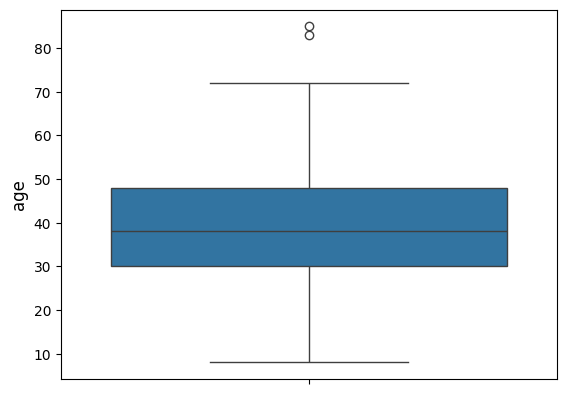

In [232]:
import seaborn as sns

sns.boxplot(data_preapprove["age"])

In [233]:
data_preapprove["bundle_nm"].value_counts().sum()

8215

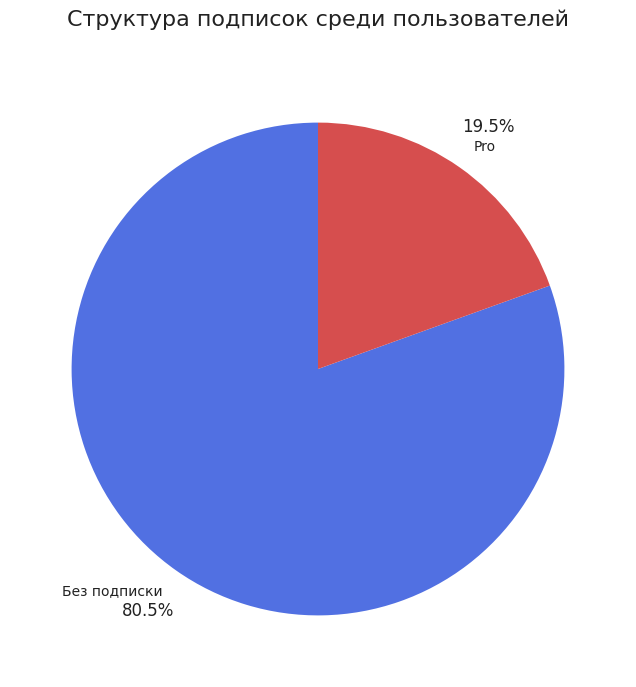

In [234]:
# Customizing our pie chart
colors = ['#5170E2', '#D64E4E', '#565454']
subs = data_preapprove["bundle_nm"].value_counts()
bundle_group_labels = data_preapprove["bundle_nm"].unique()
font_color = '#222222'

plt.rcParams.update({
'font.size': 12, # Общий размер шрифта для текста
'axes.titlesize': 14, # Размер шрифта для заголовков осей
'axes.labelsize': 12, # Размер шрифта для подписей осей
'xtick.labelsize': 10, # Размер шрифта для меток на оси X
'ytick.labelsize': 10 # Размер шрифта для меток на оси Y
})

plt.figure(figsize=(8, 8))
plt.pie(subs, labels=bundle_group_labels, autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=1.2, radius=1, textprops={'color':font_color})
title = plt.title('Структура подписок среди пользователей', fontsize=16, color=font_color, pad=25)
plt.savefig('pie_chart.png', format='png')
plt.show()
        

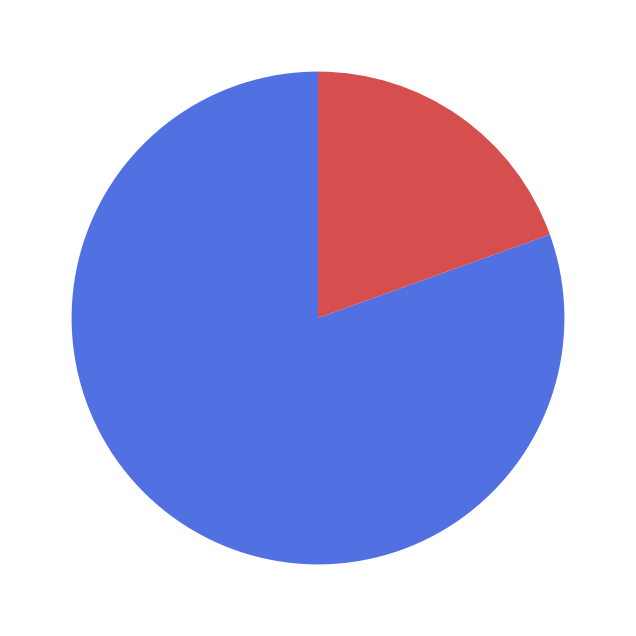

In [235]:
# Customizing our pie chart
colors = ['#5170E2', '#D64E4E', '#565454']
subs = data_preapprove["bundle_nm"].value_counts()
# bundle_group_labels = data_preapprove["bundle_nm"].unique()
# font_color = '#222222'

# plt.rcParams.update({
# 'font.size': 12, # Общий размер шрифта для текста
# 'axes.titlesize': 14, # Размер шрифта для заголовков осей
# 'axes.labelsize': 12, # Размер шрифта для подписей осей
# 'xtick.labelsize': 10, # Размер шрифта для меток на оси X
# 'ytick.labelsize': 10 # Размер шрифта для меток на оси Y
# })

plt.figure(figsize=(8, 8))
plt.pie(subs, startangle=90, colors=colors)
# title = plt.title('Структура подписок среди пользователей', fontsize=16, color=font_color, pad=25)
plt.savefig('pie_chart.png', format='png')
plt.show()
        

In [236]:
data_preapprove = data_preapprove.loc[data_preapprove["bundle_nm"] != 'Premium']

In [237]:
data_preapprove["bundle_nm"].value_counts()

bundle_nm
Без подписки    6613
Pro             1602
Name: count, dtype: int64

In [238]:
data_preapprove["gender_cd"].isna().sum()

65

In [239]:
data_preapprove["child_flg"].isna().sum()

KeyError: 'child_flg'

In [ ]:
data_preapprove.groupby("bundle_nm")["child_flg"].mean().reset_index()

,bundle_nm,child_flg
0,Pro,0.254444
1,Без подписки,0.140403


In [ ]:
data_preapprove.groupby("bundle_nm")["gender_cd"].mean().reset_index()

,bundle_nm,gender_cd
0,Pro,0.517837
1,Без подписки,0.487642


In [ ]:
data_preapprove.groupby("bundle_nm")["holiday_flg"].mean().reset_index()

,bundle_nm,holiday_flg
0,Pro,0.091111
1,Без подписки,0.071258


In [ ]:
data_preapprove.groupby("bundle_nm")["approval_flg"].mean().reset_index()

,bundle_nm,approval_flg
0,Pro,0.033333
1,Без подписки,0.045627
